# 🏡 Ames Housing — Real Estate EDA
**Author:** Daniil Zuiev
**Goal:** Understand which factors most influence house prices in Ames, Iowa.
**Dataset:** Ames Housing (79 features)
**Tools:** Python, Pandas, Seaborn, Matplotlib
**Focus:** Real Estate Analytics + ML Feature Engineering


## 📘 Project Overview

This notebook performs a clean and structured Exploratory Data Analysis (EDA)
on the Ames Housing dataset — one of the most commonly used datasets in real estate ML.

### Objectives:
- Identify key drivers of house prices
- Understand relationships between features
- Prepare clean data for machine learning
- Build insights for future modeling

We focus on:
- Numeric features (area, basement, garage, quality)
- Categorical features (neighborhood, condition, style)
- Time-related features (year built, year remodeled, year sold)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import os
from utilities.plotting import set_style, save_plot

os.makedirs("../output/graphs", exist_ok=True)
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

set_style()
# %% Load Data
df = pd.read_csv('../data/AmesHousing.csv')

selected_cols = [
    "SalePrice",

    "Gr Liv Area", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF",
    "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF",
    "Garage Area", "Garage Cars",
    "Lot Area", "Lot Frontage",
    "Mas Vnr Area",
    "Wood Deck SF", "Open Porch SF",

    "Overall Qual", "Overall Cond",
    "Exter Qual", "Exter Cond",
    "Kitchen Qual", "Heating QC",
    "Bsmt Qual", "Bsmt Cond",
    "Fireplace Qu", "Garage Qual", "Garage Cond",

    "Year Built", "Year Remod/Add", "Yr Sold", "Mo Sold", "Garage Yr Blt",

    "Neighborhood", "Condition 1", "Condition 2",
    "Lot Config", "Land Slope",
    "Bldg Type", "House Style",
    "Foundation", "Roof Style",
    "Exterior 1st", "Exterior 2nd"
]

df = df[selected_cols].copy()
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('/', '_')

df = df.drop_duplicates()

## 🔍 Data Loading & Basic Structure

We load the dataset and keep only the most important features for real estate price prediction:
- Size-related features (living area, basement, garage, lot)
- Quality and condition ratings
- Location-related features
- Construction and renovation years

Columns are normalized to `snake_case` to keep the dataset consistent and ready for ML pipelines.


In [5]:
# %% Handle missing values
df['lot_frontage'] = df['lot_frontage'].fillna(df['lot_frontage'].median())
df['garage_yr_blt'] = df['garage_yr_blt'].fillna(df['year_built'])
df['mas_vnr_area'] = df['mas_vnr_area'].fillna(0)

cols_none = [
    "bsmt_qual", "bsmt_cond",
    "bsmtfin_sf_1", "bsmtfin_sf_2",
    "fireplace_qu",
    "garage_qual", "garage_cond"
]

for col in cols_none:
    if col in df.columns:
        df[col] = df[col].fillna("None")

## 🧼 Data Cleaning

We handle missing values in a way that preserves real-estate meaning:

- `lot_frontage` → filled with median (continuous variable)
- `garage_yr_blt` → filled with `year_built` (garage usually matches main building)
- `mas_vnr_area` → filled with 0 (no masonry = 0 area)
- Basement / Garage / Fireplace quality columns → `"None"` (meaning “no basement/garage/fireplace”)

This ensures:
- No artificial bias
- No invalid NaN categories
- The data matches real-world semantics


In [6]:
# %% Convert types
for col in ['year_built', 'year_remod_add']:
    if col in df.columns:
        df[col] = df[col].astype(int)

cat_cols = [
    "exter_qual", "exter_cond", "kitchen_qual", "heating_qc",
    "bsmt_qual", "bsmt_cond", "fireplace_qu", "garage_qual", "garage_cond",
    "neighborhood", "condition_1", "condition_2",
    "lot_config", "land_slope",
    "bldg_type", "house_style",
    "foundation", "roof_style",
    "exterior_1st", "exterior_2nd"
]

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

## 📈 1. Distribution of SalePrice

Understanding the distribution of the target variable is a critical first step.
Real estate prices are usually **right-skewed**, with a large number of mid-priced homes
and a few very expensive properties.


Saved: ../output/graphs/saleprice_distribution.png


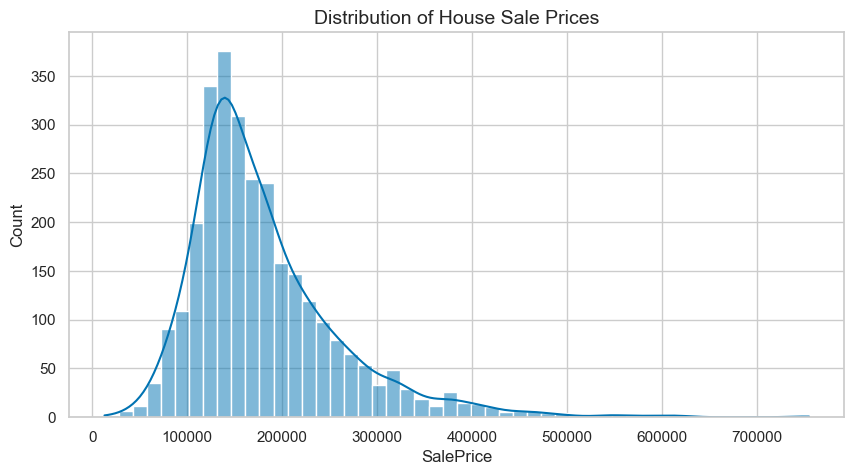

In [7]:
# %% Distribution of SalePrice
sns.histplot(df['saleprice'], bins=50, kde=True)
plt.title('Distribution of House Sale Prices')
plt.xlabel('SalePrice')
plt.ylabel('Count')
save_plot("saleprice_distribution.png")
plt.show()


### 📌 Insights:
- Sale prices are **right-skewed**.
- Most houses fall into the **120,000–200,000 USD** range.
- There is a long tail of expensive properties up to 750,000+ USD.
- This distribution is **not normal**, which affects ML models.

### 📌 Why it matters:
Linear models work better when the target variable is closer to normal distribution.


## 📉 2. Log-Transformed SalePrice

Log-transforming the target helps:
- Reduce skew
- Stabilize variance
- Improve linear model performance


Saved: ../output/graphs/saleprice_log_distribution.png


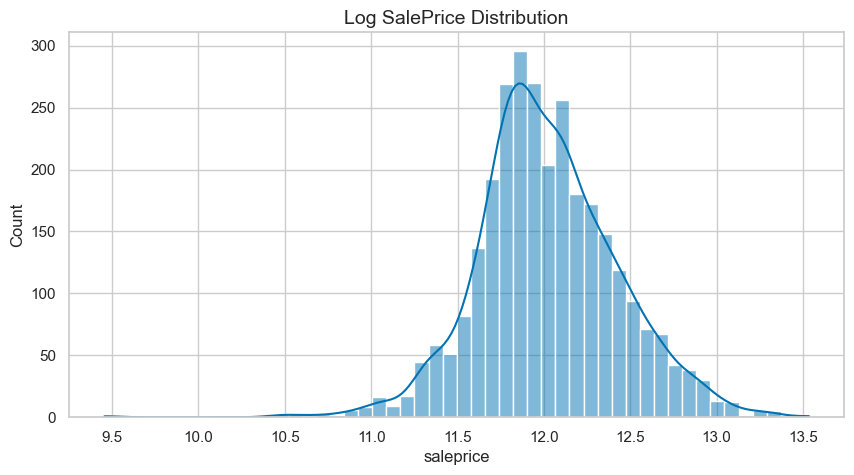

In [8]:
# %% Log-transformed distribution
sns.histplot(np.log1p(df['saleprice']), bins=50, kde=True)
plt.title('Log SalePrice Distribution')
save_plot("saleprice_log_distribution.png")
plt.show()

### 📌 Insights:
- Log-transformed SalePrice becomes **much closer to normal**.
- The long right tail disappears.
- This transformation is ideal for linear/log-linear ML models such as:
  - Linear Regression
  - Lasso / Ridge
  - ElasticNet


## 🏠 3. Living Area vs Price

Living area (`GrLivArea`) is one of the strongest predictors of house price.

We expect:
- A positive correlation
- Some variability at high values (luxury homes)


Saved: ../output/graphs/grlivarea_vs_saleprice.png


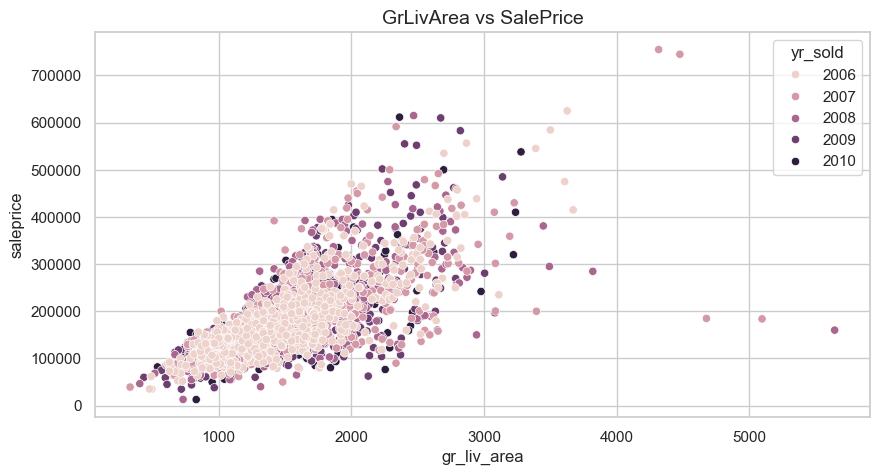

In [9]:
# %% Scatter: Living area vs Price
sns.scatterplot(x='gr_liv_area', y='saleprice', hue='yr_sold', data=df)
plt.title('GrLivArea vs SalePrice')
save_plot("grlivarea_vs_saleprice.png")
plt.show()

### 📌 Insights:
- Strong **positive linear relationship**.
- Houses > 4000 sq ft show more price variability (luxury segment).
- A few large houses sold cheap → potential *outliers*.


## 🧱 4. Overall Quality vs Price

Quality scores (`OverallQual`) are one of the most influential categorical features.
Boxplots reveal how median and variability of price rise with quality.


Saved: ../output/graphs/overallqual_vs_saleprice.png


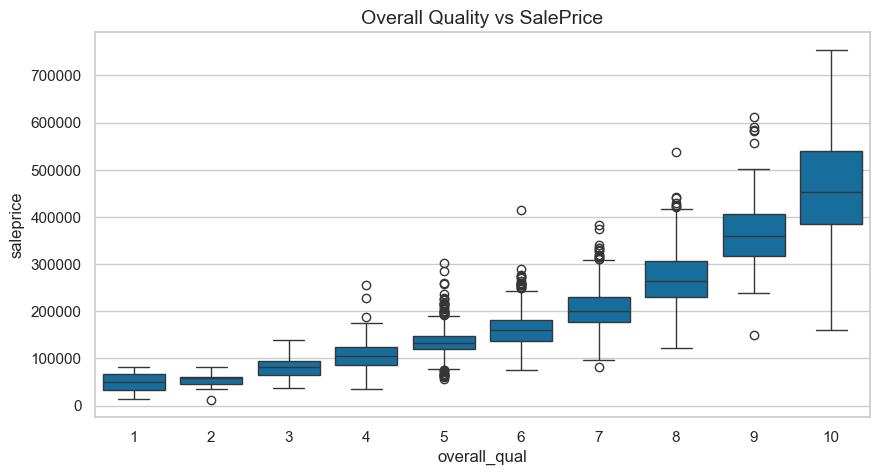

In [10]:
# %% Boxplot: Quality vs Price
sns.boxplot(x='overall_qual', y='saleprice', data=df)
plt.title('Overall Quality vs SalePrice')
save_plot("overallqual_vs_saleprice.png")
plt.show()

### 📌 Insights:
- Prices increase **monotonically** with quality.
- Homes with quality 8–10 cost **2–3×** more than low-quality homes.
- Extremely strong relationship → top ML feature.


## 🔥 5. Correlation Heatmap

We analyze numerical correlations to find the strongest predictors of SalePrice.


Saved: ../output/graphs/correlation_heatmap.png


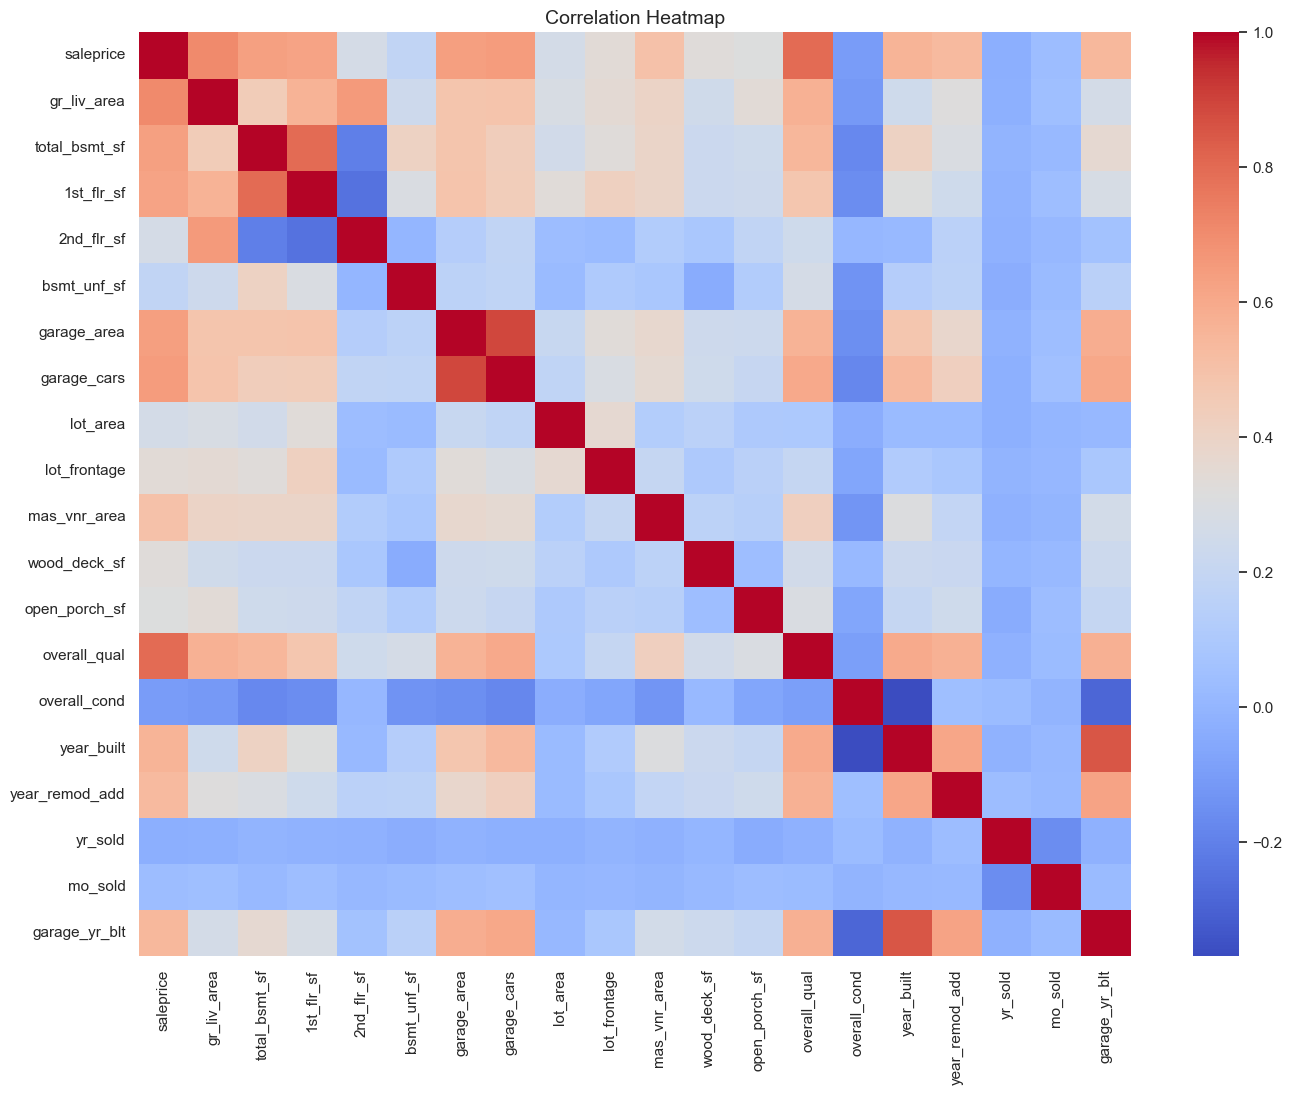

In [11]:
# %% Correlation matrix
numeric_df = df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(16, 12))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
plt.title('Correlation Heatmap')
save_plot("correlation_heatmap.png")
plt.show()

### 📌 Key correlated features:
1. Overall Qual
2. Gr Liv Area
3. Garage Cars / Garage Area
4. Total Bsmt SF
5. 1st Flr SF
6. Year Built

These features will form the core of the future ML model.


## 🎯 6. Correlation with SalePrice Only


Saved: ../output/graphs/corr_with_saleprice.png


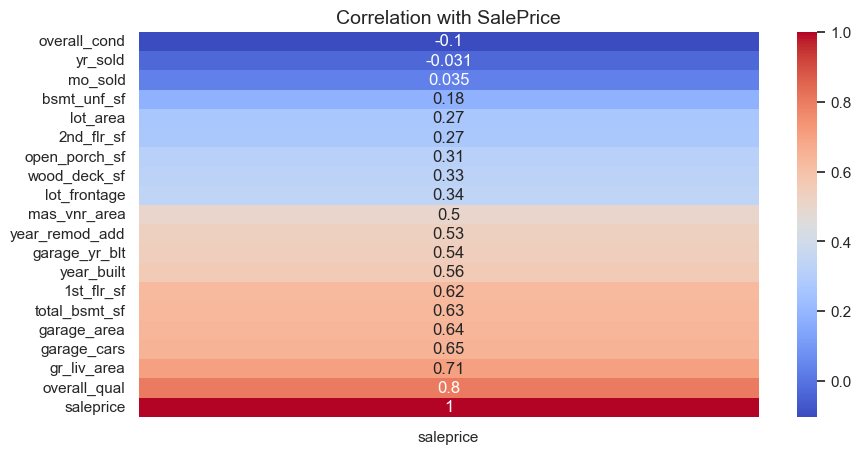

In [12]:
# %% Correlation with SalePrice
corr_target = numeric_df.corr()[['saleprice']].sort_values('saleprice')
sns.heatmap(corr_target, annot=True, cmap="coolwarm")
plt.title('Correlation with SalePrice')
save_plot("corr_with_saleprice.png")
plt.show()

### 📌 Insights:
The strongest predictors are:
- OverallQual
- GrLivArea
- GarageCars
- YearBuilt
- TotalBsmtSF

This matches real estate market intuition:
Better quality + more space = higher price.


## 📅 7. Year Built × Year Sold

We explore how the construction year interacts with sale year.
This reveals:
- Market trends
- Price appreciation over time
- Value of newer homes


Saved: ../output/graphs/pivot_yearbuilt_yrsold.png


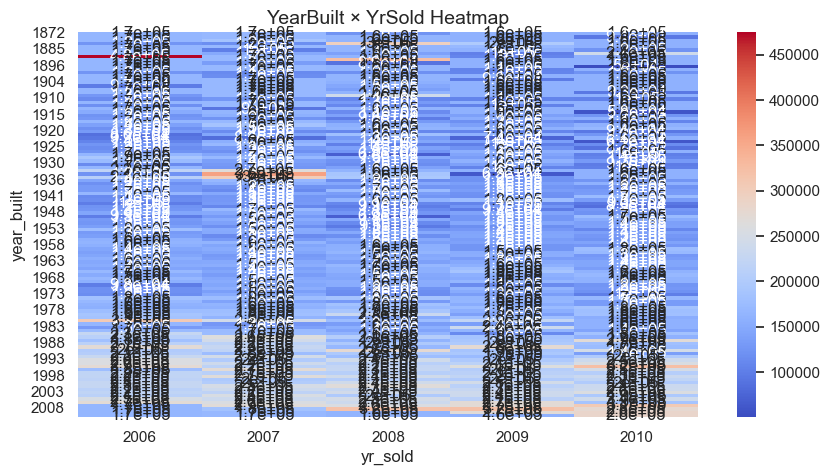

In [13]:
# %% Pivot heatmap by year built × year sold
pivot = df.pivot_table(values='saleprice', index='year_built', columns='yr_sold')
pivot = pivot.fillna(pivot.mean())
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('YearBuilt × YrSold Heatmap')
save_plot("pivot_yearbuilt_yrsold.png")
plt.show()

### 📌 Insights:
- Newer homes consistently sell higher.
- Homes built after 2000 show a clear higher-price cluster.


## 🔍 8. Pairplot (Feature Relationships)


Saved: ../output/graphs/pairplot_grlivarea_saleprice.png


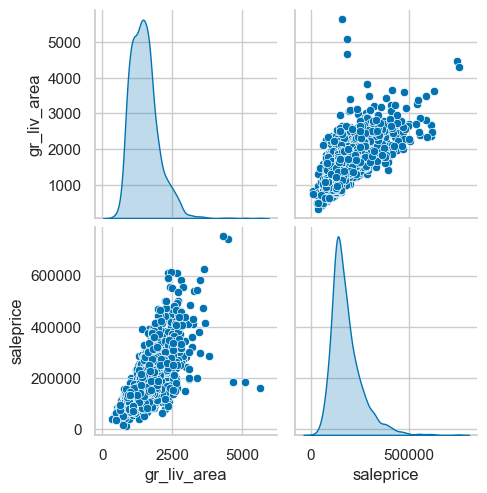

In [14]:
# %% Pairplot
sns.pairplot(df[['gr_liv_area', 'saleprice']], diag_kind='kde')
save_plot("pairplot_grlivarea_saleprice.png")
plt.show()

# ✅ Final Summary & Business Insights

### 🔑 Key Drivers of House Price:
- **Overall quality** (strongest predictor)
- **Living area (GrLivArea)**
- **Garage size / basement size**
- **Year built**
- **Neighborhood**

### 🧠 Business Interpretation:
- Investing in quality renovations likely increases home value.
- Larger homes bring predictably higher prices.
- Newer homes command a premium.
- Location (neighborhood) plays a major role in pricing.

### 🔧 ML Readiness:
This dataset is now:
- Clean
- Well-structured
- With proper dtypes
- With filled missing values
- Ready for feature engineering & modeling

Next step → **build the first ML model (Linear Regression + Regularization)**.
